In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import math
from functools import partial

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.numpy as np
import matplotlib.pyplot as plt

from IMNN.experimental.jax.imnn import (
    AggregatedGradientIMNN,
    AggregatedNumericalGradientIMNN,
    AggregatedSimulatorIMNN,
    GradientIMNN,
    NumericalGradientIMNN,
    SimulatorIMNN,
)
from IMNN.experimental.jax.lfi import (
    ApproximateBayesianComputation,
    GaussianApproximation,
)
from IMNN.experimental.jax.utils import value_and_jacrev

rng = jax.random.PRNGKey(0)

# Model in STAX

In [3]:
n_summaries = 5
n_s = 1000
n_d = 1000
λ = 10.0
ϵ = 0.1

In [4]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries),
)

In [5]:
optimiser = optimizers.adam(step_size=1e-3)

# Random seeds for IMNN

In [6]:
rng, initial_model_key = jax.random.split(rng)
rng, fitting_key = jax.random.split(rng)

# Random seeds for ABC

In [7]:
rng, abc_key = jax.random.split(rng)

# Simulator in JAX

In [8]:
θ_fid = np.array([0.0, 1.0])
δθ = np.array([0.1, 0.1])
n_params = 2
input_shape = (10,)
simulator_args = {"input shape": input_shape}

In [9]:
def simulator(rng, θ, simulator_args=simulator_args):
    μ, Σ = θ

    def fn(key, μ, Σ):
        return μ + np.sqrt(Σ) * jax.random.normal(
            key, shape=simulator_args["input shape"]
        )

    if μ.shape == Σ.shape:
        if len(μ.shape) == 0:
            return fn(rng, μ, Σ)
        else:
            keys = jax.random.split(rng, num=μ.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, μ, Σ: simulator(key, (μ, Σ), simulator_args=simulator_args)
            )(keys, μ, Σ)
    else:
        if len(μ.shape) > 0:
            keys = jax.random.split(rng, num=μ.shape[0] + 1)
            rng = keys[0]
            keys = keys[1:]
            return jax.vmap(
                lambda key, μ: simulator(key, (μ, Σ), simulator_args=simulator_args)
            )(keys, μ)
        elif len(Σ.shape) > 0:
            keys = jax.random.split(rng, num=Σ.shape[0])
            return jax.vmap(
                lambda key, Σ: simulator(key, (μ, Σ), simulator_args=simulator_args)
            )(keys, Σ)

In [10]:
def simulator_gradient(rng, θ, simulator_args=simulator_args):
    return value_and_jacrev(simulator, argnums=1)(rng, θ, simulator_args=simulator_args)

In [11]:
def get_simulations(rng, n_s, θ, simulator_args=simulator_args):
    def get_simulator(key):
        return simulator(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_simulator)(np.array(keys))


def get_simulation_gradients(rng, n_s, n_d, θ, simulator_args=simulator_args):
    def get_batch_gradient(key):
        return simulator_gradient(key, θ, simulator_args=simulator_args)

    keys = jax.random.split(rng, num=n_s)
    return jax.vmap(get_batch_gradient)(np.array(keys)[:n_d])

In [12]:
rng, *training_keys = jax.random.split(rng, num=1 + n_s)

In [13]:
fiducial, derivative = jax.vmap(
    partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args)
)(np.array(training_keys))

In [14]:
numerical_derivative = np.stack(
    [
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] - δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] - δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
            ],
            1,
        ),
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] + δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] + δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(training_keys)),
            ],
            1,
        ),
    ],
    1,
)

In [15]:
rng, *validation_keys = jax.random.split(rng, num=1 + n_s)

In [16]:
validation_fiducial, validation_derivative = jax.vmap(
    partial(simulator_gradient, θ=θ_fid, simulator_args=simulator_args)
)(np.array(validation_keys))

In [17]:
validation_numerical_derivative = np.stack(
    [
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] - δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] - δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
            ],
            1,
        ),
        np.stack(
            [
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0] + δθ[0] / 2.0, θ_fid[1]),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
                jax.vmap(
                    partial(
                        simulator,
                        θ=(θ_fid[0], θ_fid[1] + δθ[1] / 2.0),
                        simulator_args=simulator_args,
                    )
                )(np.array(validation_keys)),
            ],
            1,
        ),
    ],
    1,
)

# Initialise IMNN

In [18]:
IMNNs = [
    SimulatorIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
    ),
    AggregatedSimulatorIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        devices=jax.devices(),
        n_per_device=n_s // 2,
    ),
    SimulatorIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
    ),
    AggregatedSimulatorIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        simulator=lambda rng, θ: simulator(rng, θ, simulator_args=simulator_args),
        devices=jax.devices(),
        n_per_device=100,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        devices=jax.devices(),
        n_per_device=n_s // 2,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative,
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative,
        devices=jax.devices(),
        n_per_device=100,
    ),
    GradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative[:100],
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative[:100],
    ),
    AggregatedGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=derivative[:100],
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_derivative[:100],
        devices=jax.devices(),
        n_per_device=100,
    ),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
    ),
    AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        devices=jax.devices(),
        n_per_device=n_s // 2),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative,
    ),
     AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=n_d,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative,
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative,
        devices=jax.devices(),
        n_per_device=n_s // 2),
    NumericalGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative[:100],
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative[:100],
    ),
     AggregatedNumericalGradientIMNN(
        n_s=n_s,
        n_d=100,
        n_params=n_params,
        n_summaries=n_summaries,
        input_shape=input_shape,
        θ_fid=θ_fid,
        key=initial_model_key,
        model=model,
        optimiser=optimiser,
        fiducial=fiducial,
        derivative=numerical_derivative[:100],
        δθ=δθ,
        validation_fiducial=validation_fiducial,
        validation_derivative=validation_numerical_derivative[:100],
        devices=jax.devices(),
        n_per_device=100)
]

# Fit

In [19]:
IMNN_rngs = 4 * [fitting_key] + 12 * [None]
labels = [
    "Simulator\n",
    "Aggregated simulator\n",
    "Simulator\n$n_d=100$\n",
    "Aggregated simulator\n$n_d=100$\n",
    "Precomputed\n(no validation)\n",
    "Aggregated precomputed\n(no validation)\n",
    "Precomputed\n",
    "Aggregated precomputed\n",
    "Precomputed\n$n_d=100$\n",
    "Aggregated precomputed\n$n_d=100$\n",
    "Precomputed\n(numerical gradient)\n(no validation)\n",
    "Aggregated precomputed\n(numerical gradient)\n(no validation)\n",
    "Precomputed\n(numerical gradient)\n",
    "Aggregated precomputed\n(numerical gradient)\n",
    "Precomputed\n(numerical gradient)\n$n_d=100$\n",
    "Aggregated precomputed\n(numerical gradient)\n$n_d=100$\n"
]

In [20]:
[IMNN.fit(λ=λ, ϵ=ϵ, rng=IMNN_rng) for IMNN, IMNN_rng in zip(IMNNs, IMNN_rngs)];

no available validation data. setting statistics with training set
no available validation data. setting statistics with training set
no available validation data. setting statistics with training set
no available validation data. setting statistics with training set


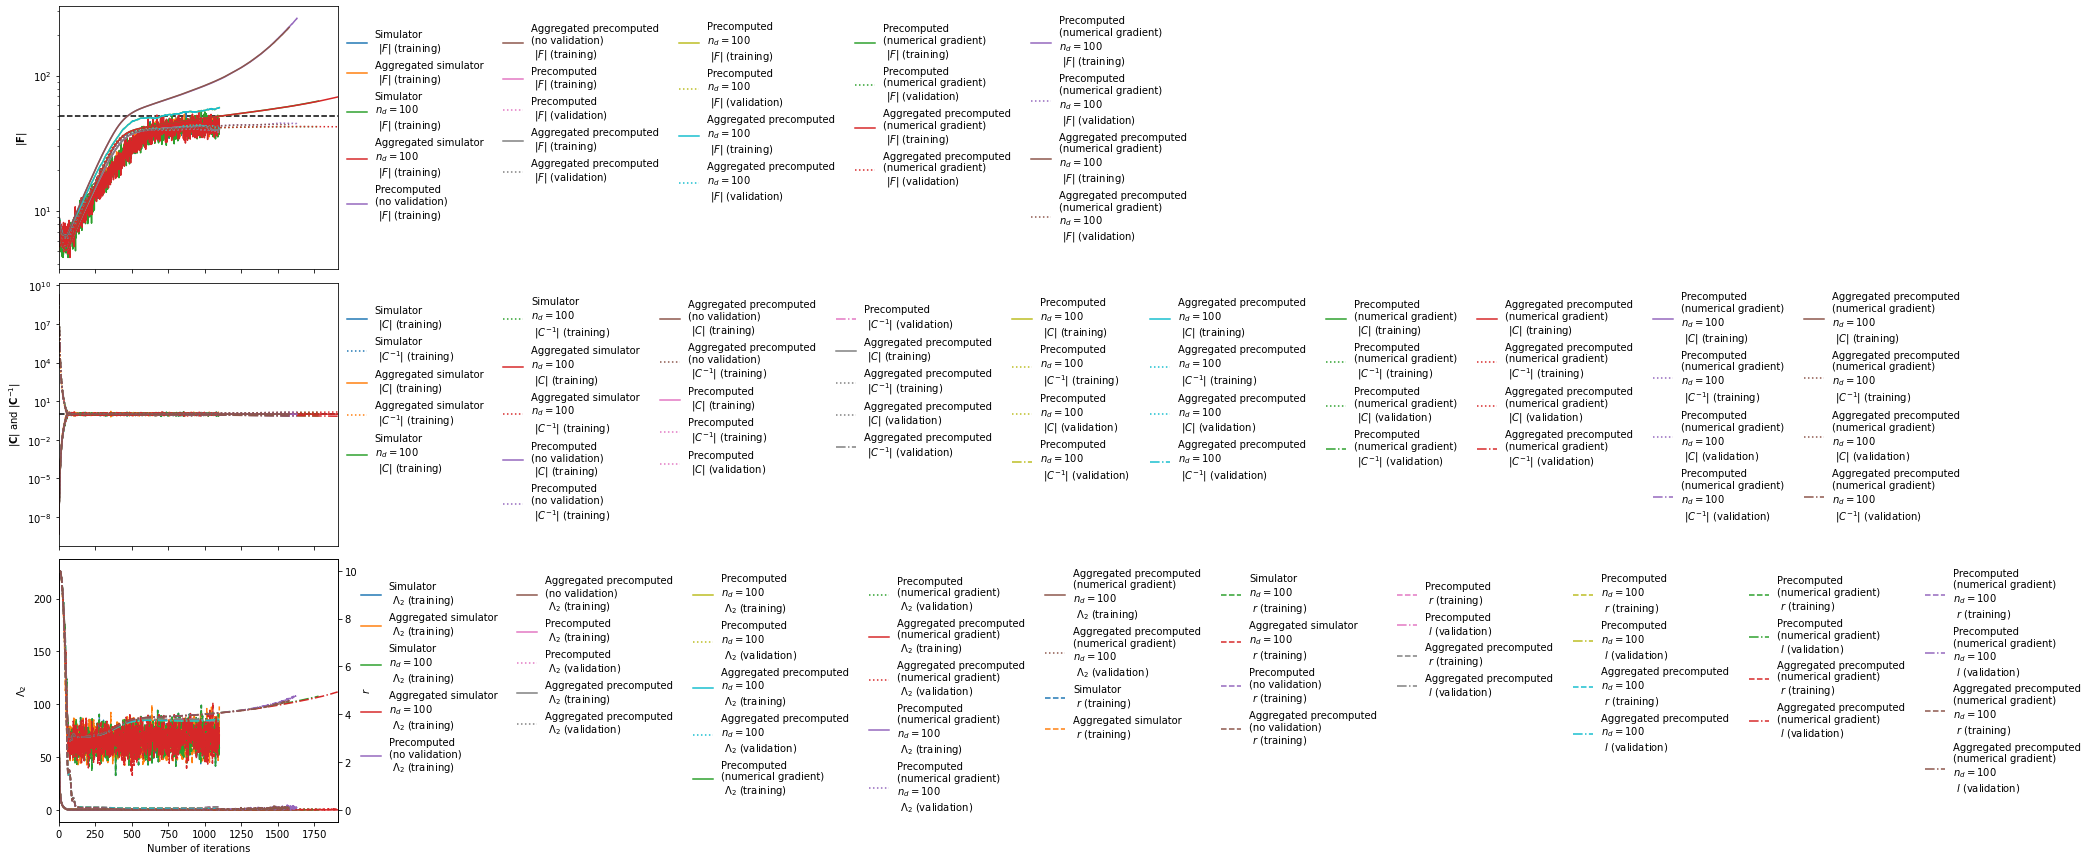

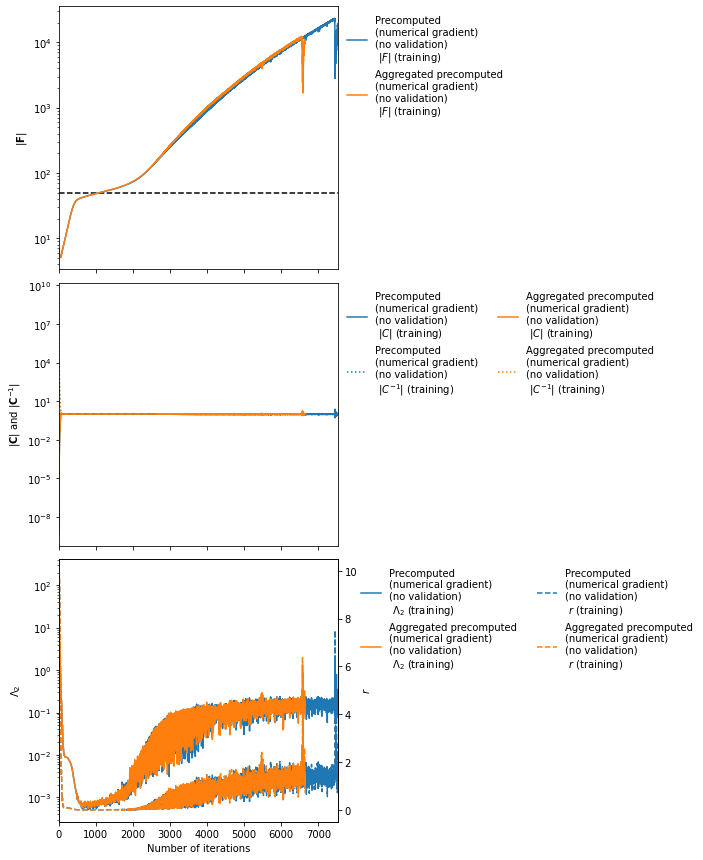

In [27]:
for i, (IMNN, label) in enumerate(zip(IMNNs, labels)):
    if i == 0:
        ax = IMNN.training_plot(expected_detF=50, colour="C{}".format(i), label=label)
    elif i == 10:
        other_ax = IMNN.training_plot(
            expected_detF=50, colour="C{}".format(i), label=label
        )
    elif i == 11:
        IMNN.training_plot(
            ax=other_ax,
            expected_detF=50, colour="C{}".format(i), label=label
        )
        other_ax[0].set_yscale("log")
        other_ax[2].set_yscale("log")
    else:
        IMNN.training_plot(
            ax=ax, expected_detF=50, colour="C{}".format(i), label=label, ncol=5
        );
ax[0].set_yscale("log")

# Data for ABC example

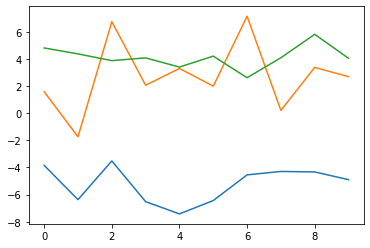

In [28]:
rng, key = jax.random.split(rng)
target_data = simulator(
    key,
    (np.array([-5.0, 2.0, 4.0]), np.array([2.0, 5.0, 1.0])),
    simulator_args=simulator_args,
)
plt.plot(target_data.T);

In [29]:
class uniform:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.event_shape = [[] for i in range(self.low.shape[0])]

    def sample(self, n=None, seed=None):
        if n is None:
            n = 1
        keys = jax.random.split(key, num=len(self.event_shape))
        return [
            jax.random.uniform(
                keys[i], shape=(n,), minval=self.low[i], maxval=self.high[i]
            )
            for i in range(len(self.event_shape))
        ]


prior = uniform([-10.0, 0.0], [10.0, 10.0])

# Gaussian approximation

In [30]:
estimates = [IMNN.get_estimate(target_data) for IMNN in IMNNs]

In [31]:
GAs = [
    GaussianApproximation(estimate, IMNN.invF, prior)
    for IMNN, estimate in zip(IMNNs, estimates)
]

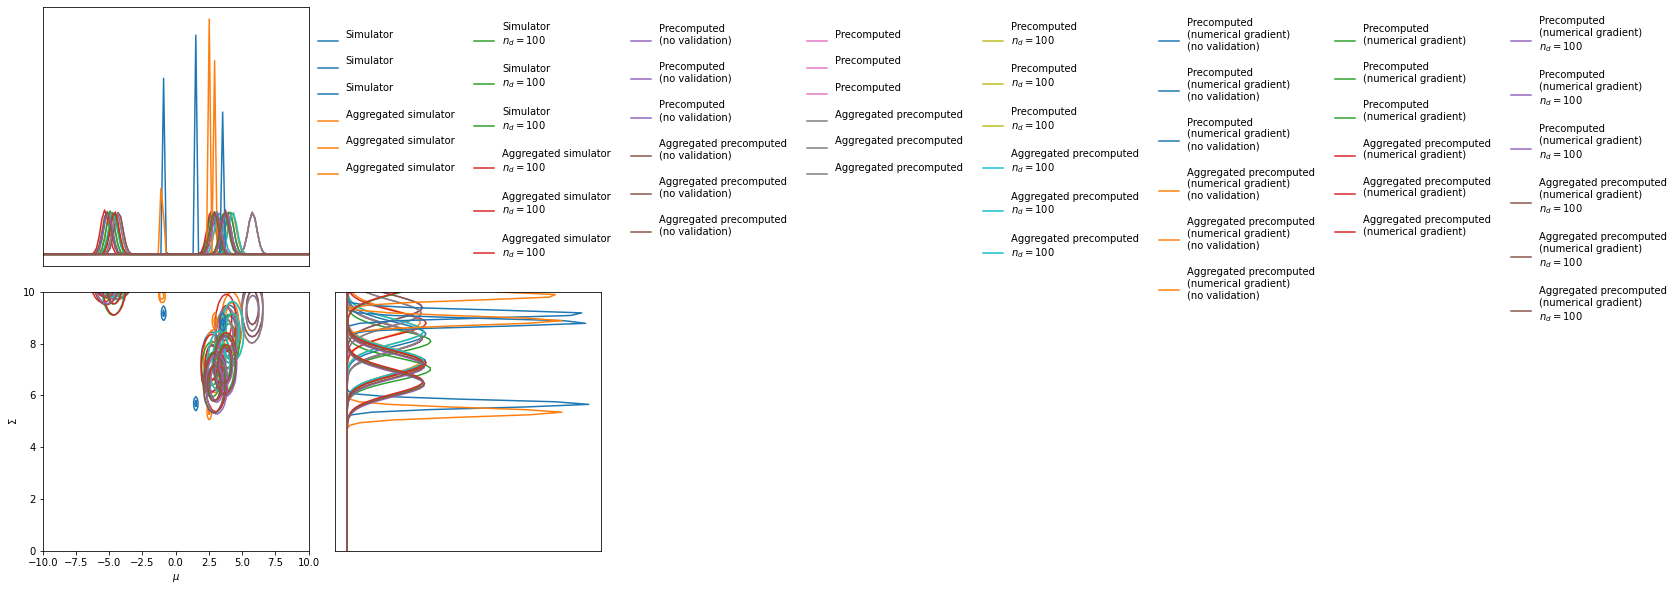

In [36]:
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax = GA.marginal_plot(
            axis_labels=[r"$\mu$", r"$\Sigma$"], label=label, colours="C{}".format(i)
        )
    else:
        GA.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

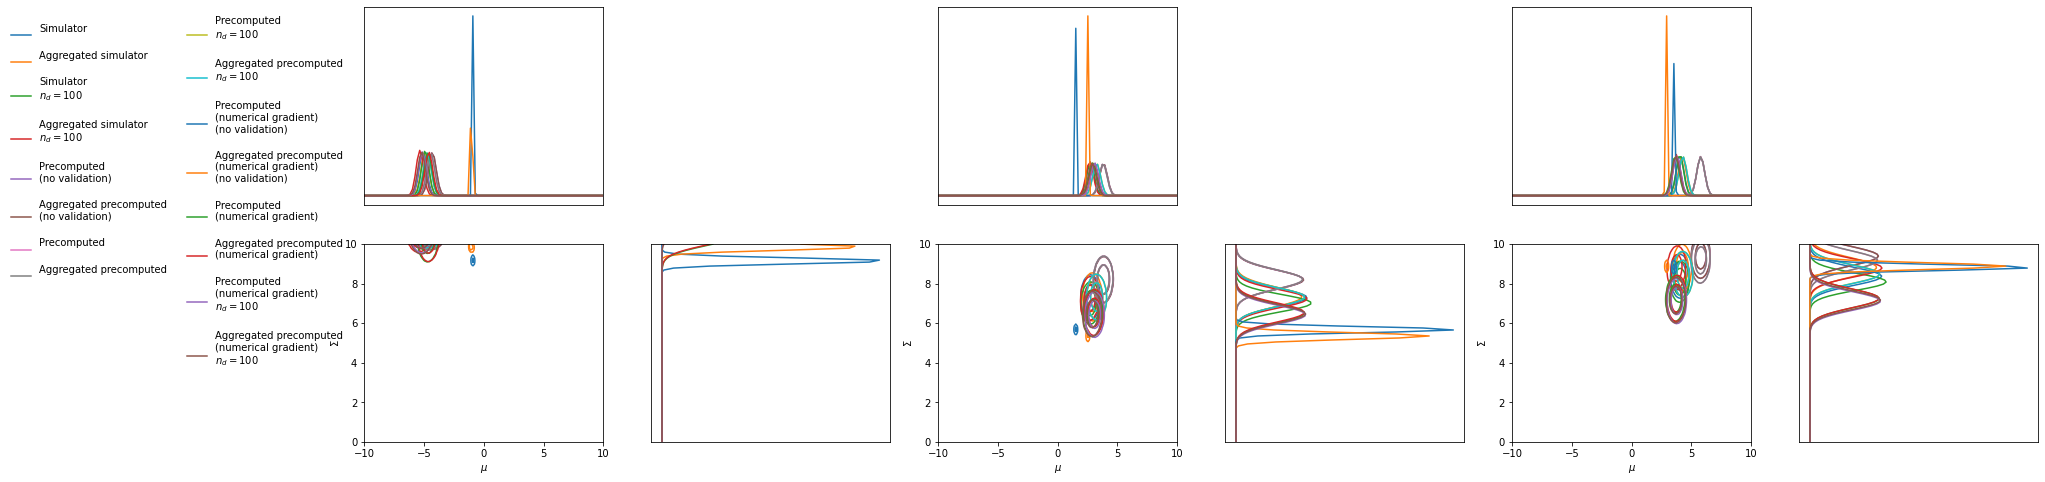

In [42]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (GA, label) in enumerate(zip(GAs, labels)):
    if i == 0:
        ax1 = GA.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = GA.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = GA.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        GA.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        GA.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        GA.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

# ABC

In [43]:
ABCs = [
    ApproximateBayesianComputation(
        target_data, prior, simulator, IMNN.get_estimate, F=IMNN.F, gridsize=50
    )
    for IMNN, estimate in zip(IMNNs, estimates)
]

In [44]:
[
    ABC(
        rng=abc_key,
        n_samples=int(1e6),
        min_accepted=100,
        max_iterations=100,
        ϵ=0.1,
        smoothing=1,
    )
    for ABC in ABCs
];

148 accepted in last 3 iterations  (3000000 simulations done). 
137 accepted in last 2 iterations  (2000000 simulations done). 
113 accepted in last 2 iterations  (2000000 simulations done). 
148 accepted in last 2 iterations  (2000000 simulations done). 
121 accepted in last 4 iterations  (4000000 simulations done). 
121 accepted in last 4 iterations  (4000000 simulations done). 
124 accepted in last 4 iterations  (4000000 simulations done). 
124 accepted in last 4 iterations  (4000000 simulations done). 
173 accepted in last 2 iterations  (2000000 simulations done). 
176 accepted in last 2 iterations  (2000000 simulations done). 
101 accepted in last 64 iterations  (64000000 simulations done). 
100 accepted in last 92 iterations  (92000000 simulations done). 
112 accepted in last 1 iterations  (1000000 simulations done). 
197 accepted in last 2 iterations  (2000000 simulations done). 
104 accepted in last 9 iterations  (9000000 simulations done). 
104 accepted in last 4 iterations  (

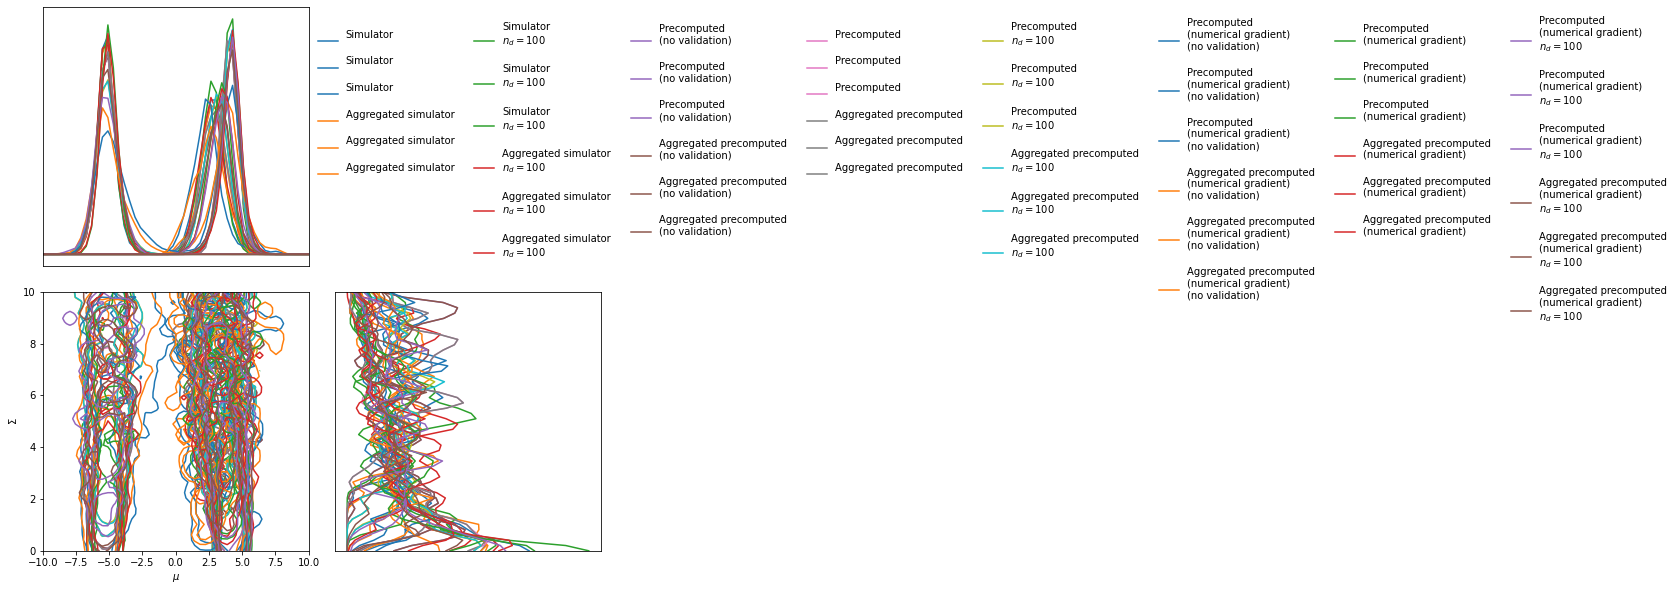

In [45]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.marginal_plot(
            axis_labels=[r"$\mu$", r"$\Sigma$"], label=label, colours="C{}".format(i)
        )
    else:
        ABC.marginal_plot(ax=ax, label=label, colours="C{}".format(i), ncol=8)

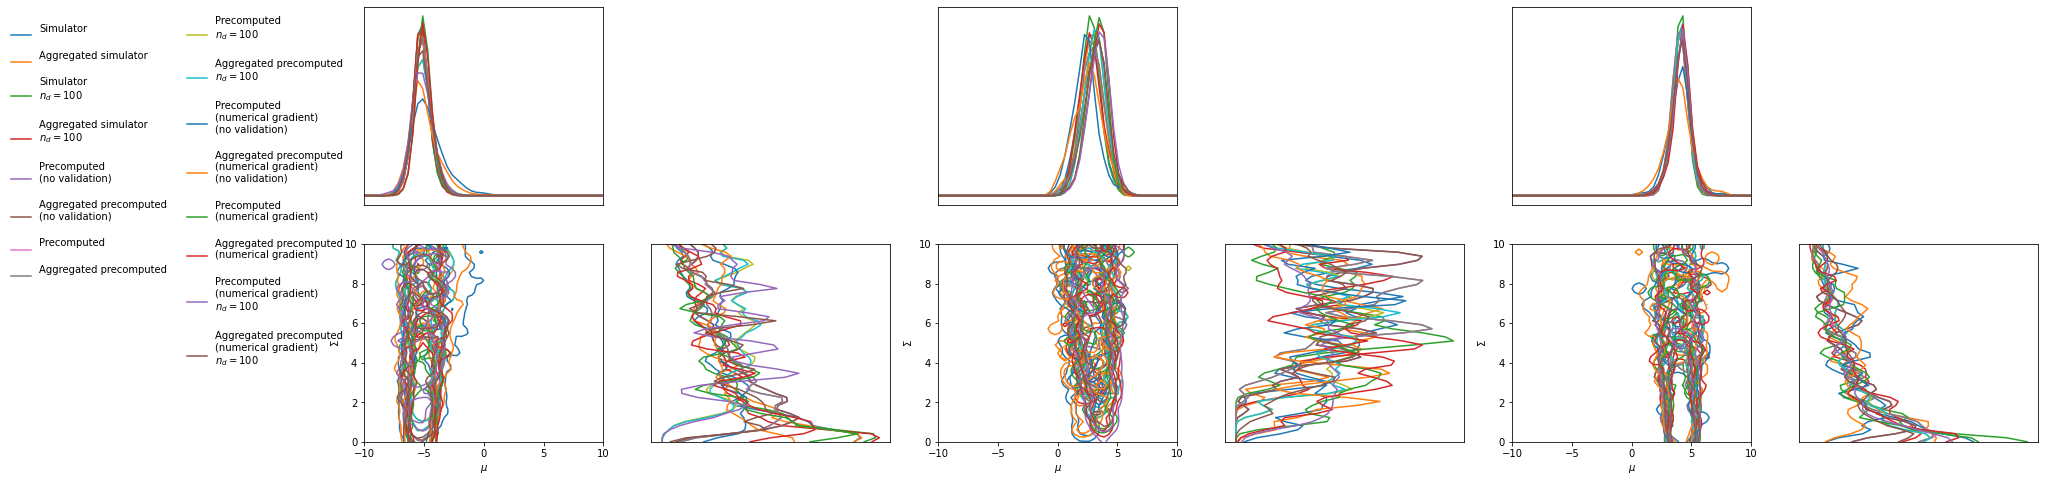

In [46]:
fig, ax = plt.subplots(2, 6, figsize=(30, 8))
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax1 = ABC.marginal_plot(
            ax=ax[:, :2],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            label=label,
            target=0,
            format=True,
            colours="C{}".format(i),
        )
        ax2 = ABC.marginal_plot(
            ax=ax[:, 2:4],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=1,
            format=True,
            colours="C{}".format(i),
        )
        ax3 = ABC.marginal_plot(
            ax=ax[:, 4:],
            axis_labels=[r"$\mu$", r"$\Sigma$"],
            target=2,
            format=True,
            colours="C{}".format(i),
        )
    else:
        ABC.marginal_plot(ax=ax1, label=label, target=0, colours="C{}".format(i), bbox_to_anchor=(-0.05, 1.0))
        ABC.marginal_plot(ax=ax2, target=1, colours="C{}".format(i))
        ABC.marginal_plot(ax=ax3, target=2, colours="C{}".format(i))

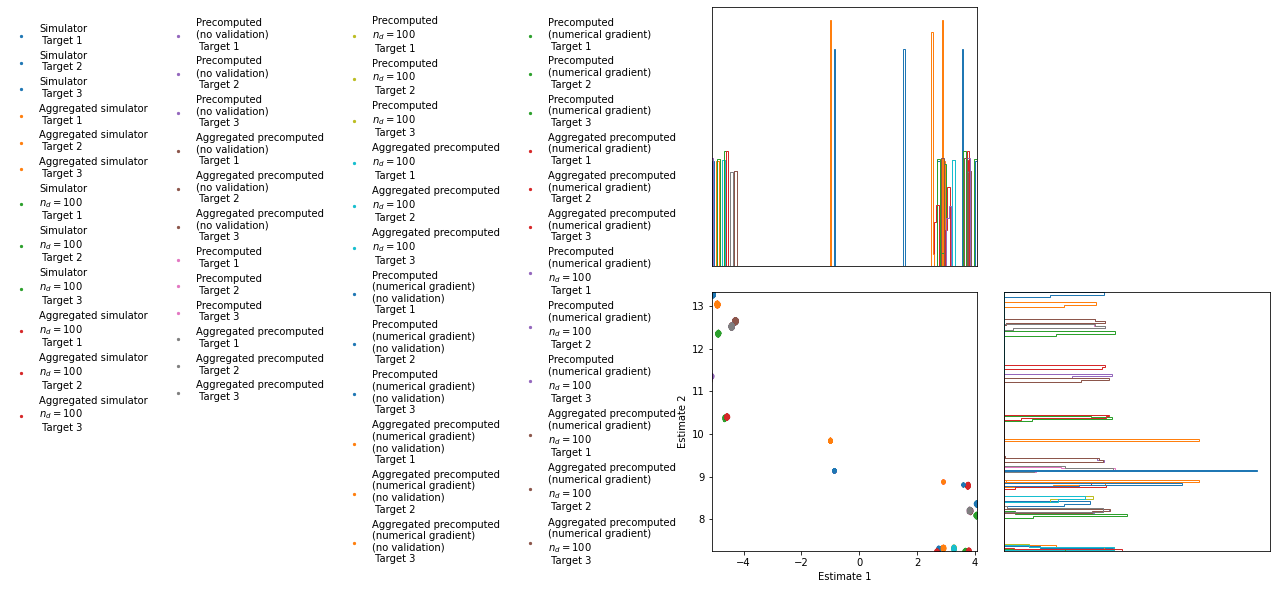

In [50]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    if i == 0:
        ax = ABC.scatter_summaries(
            axis_labels=["Estimate 1", "Estimate 2"],
            label=label,
            colours="C{}".format(i),
        )
    else:
        ABC.scatter_summaries(ax=ax, label=label, colours="C{}".format(i), ncol=4, bbox_to_anchor=(-0.1, 1.0))

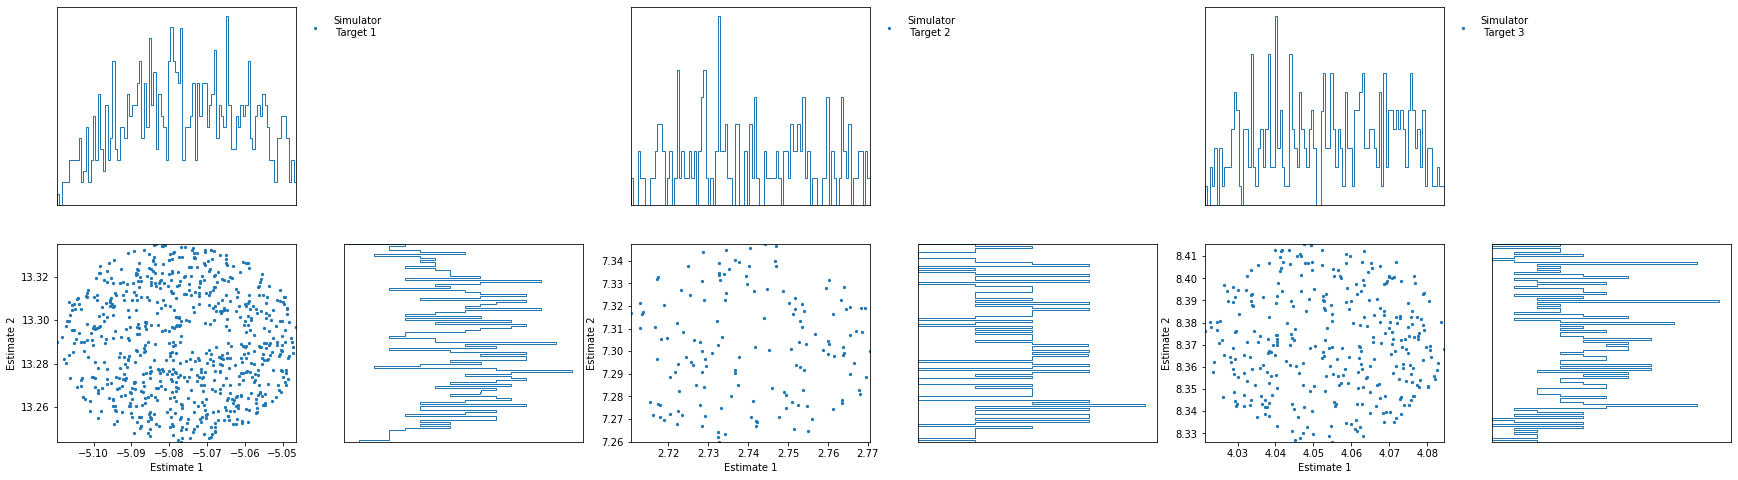

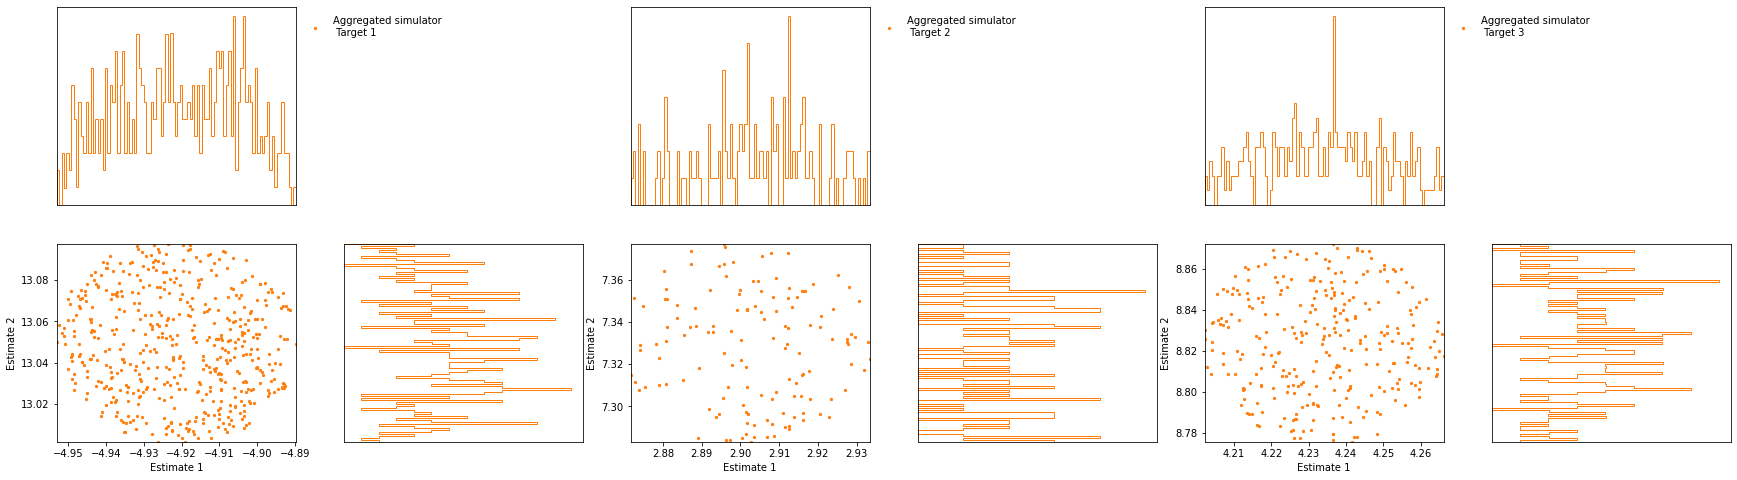

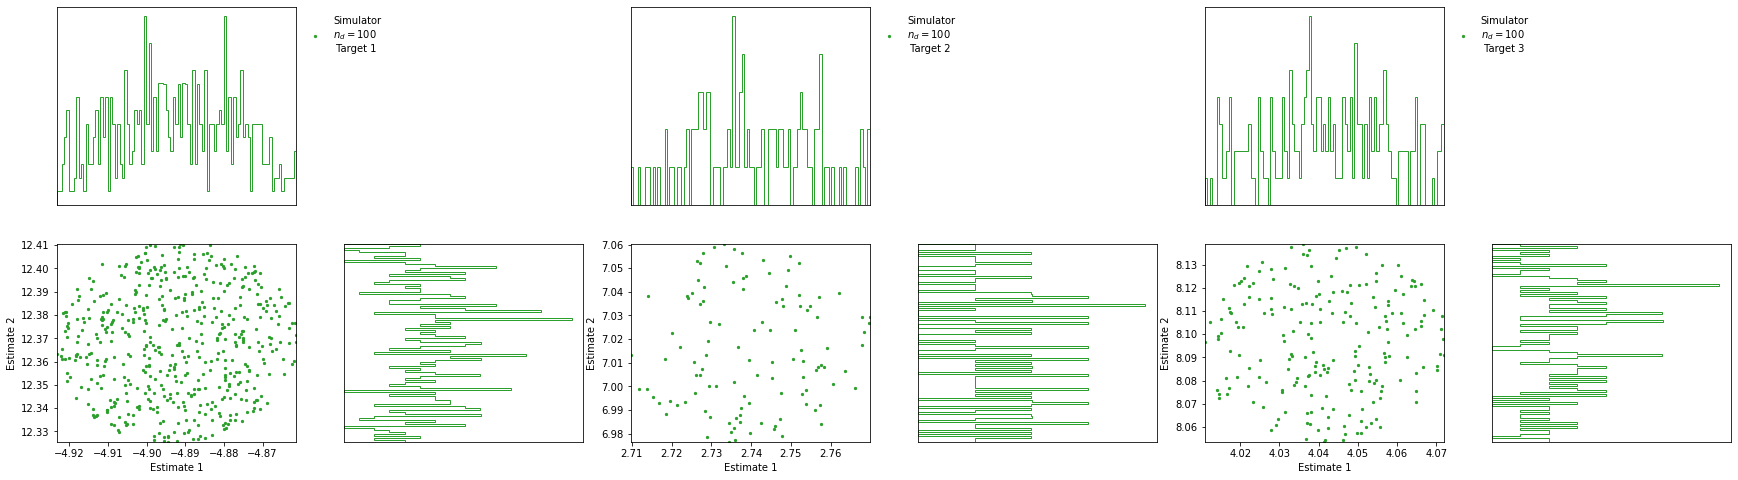

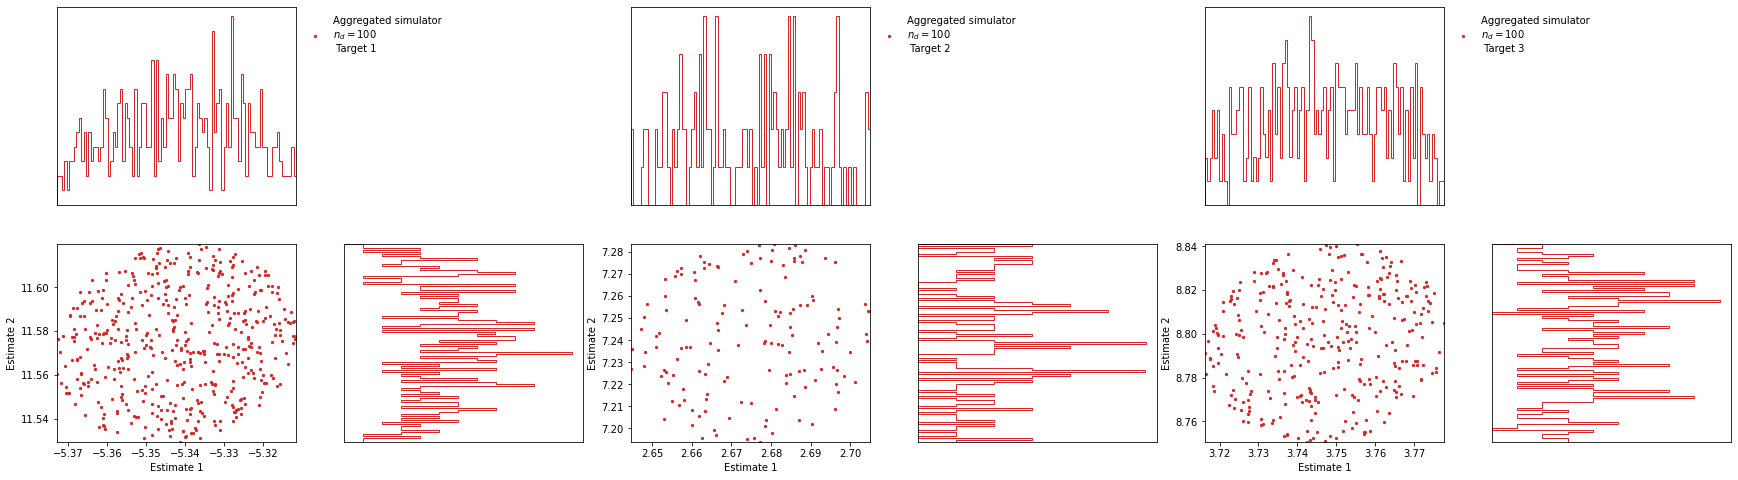

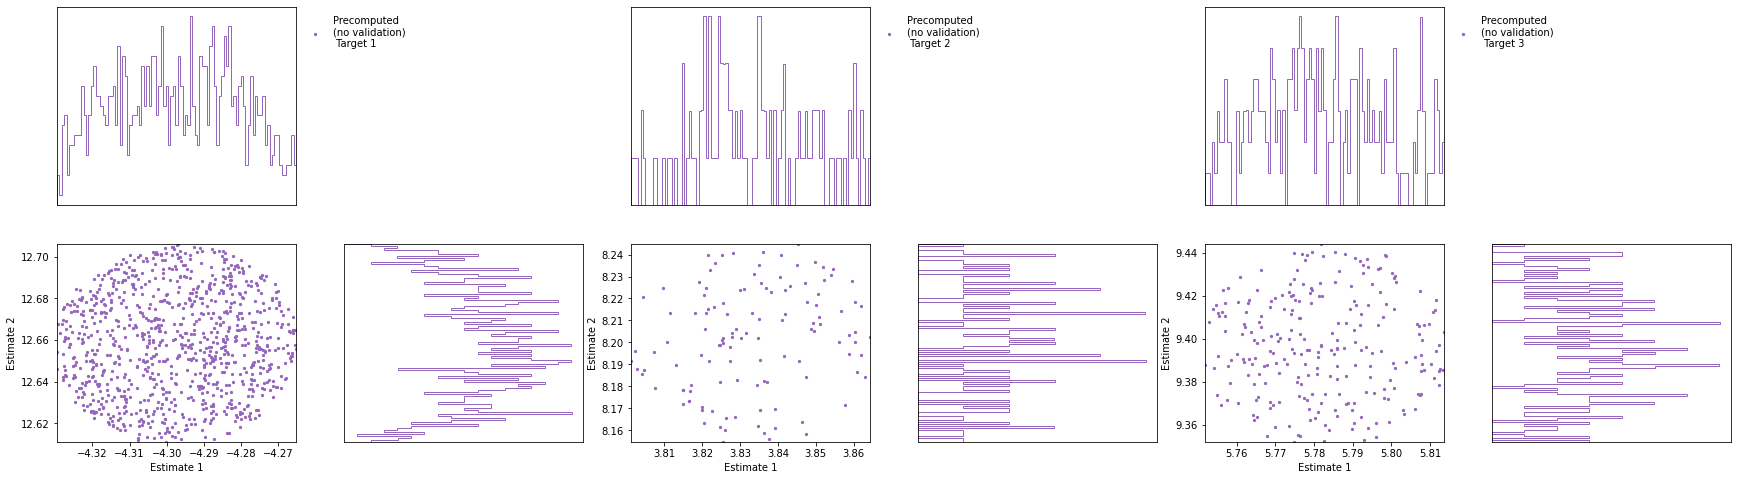

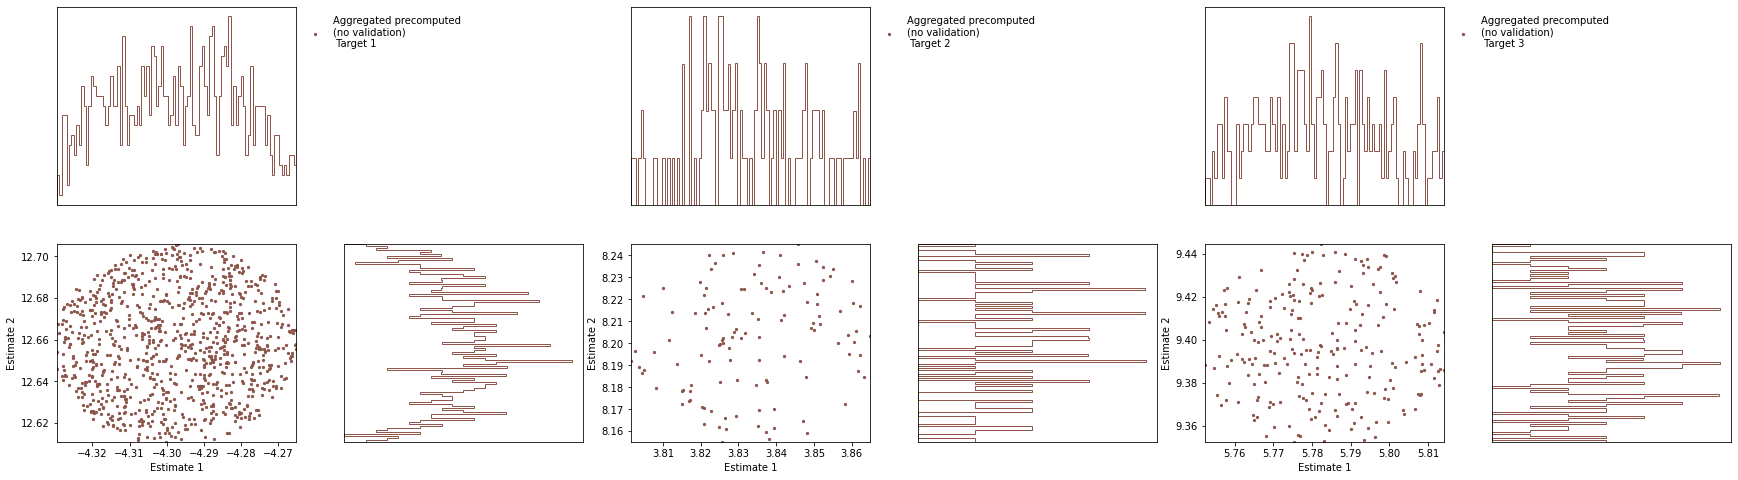

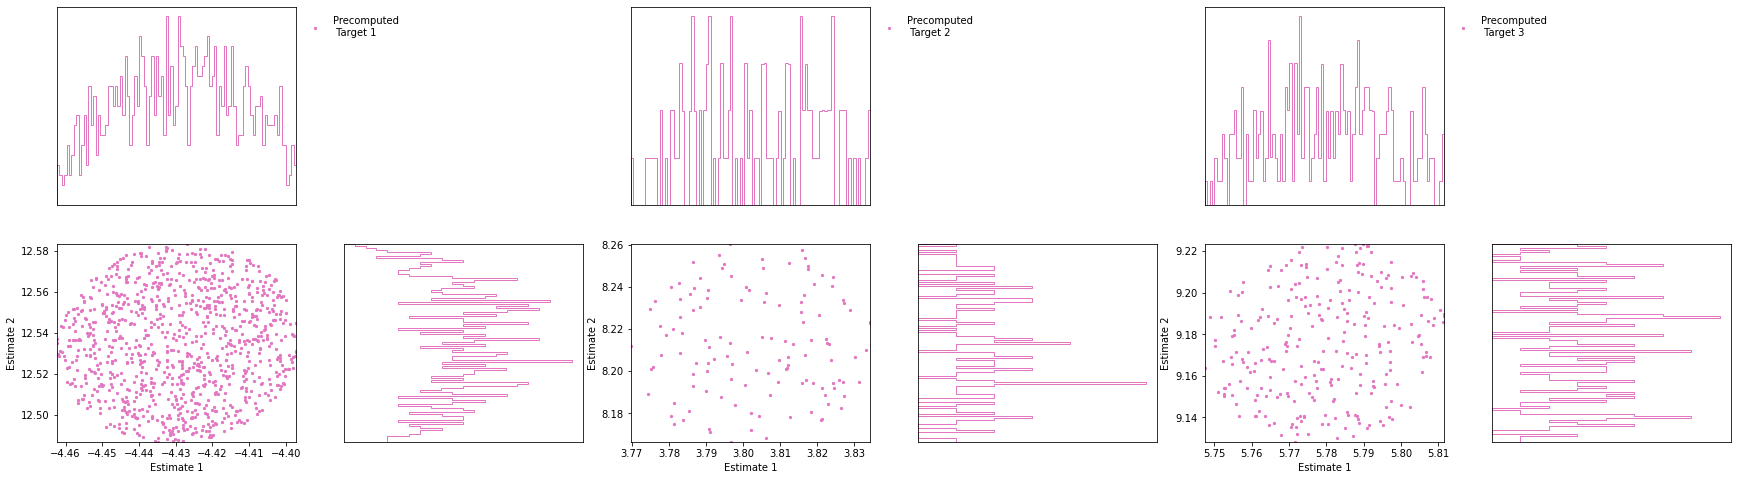

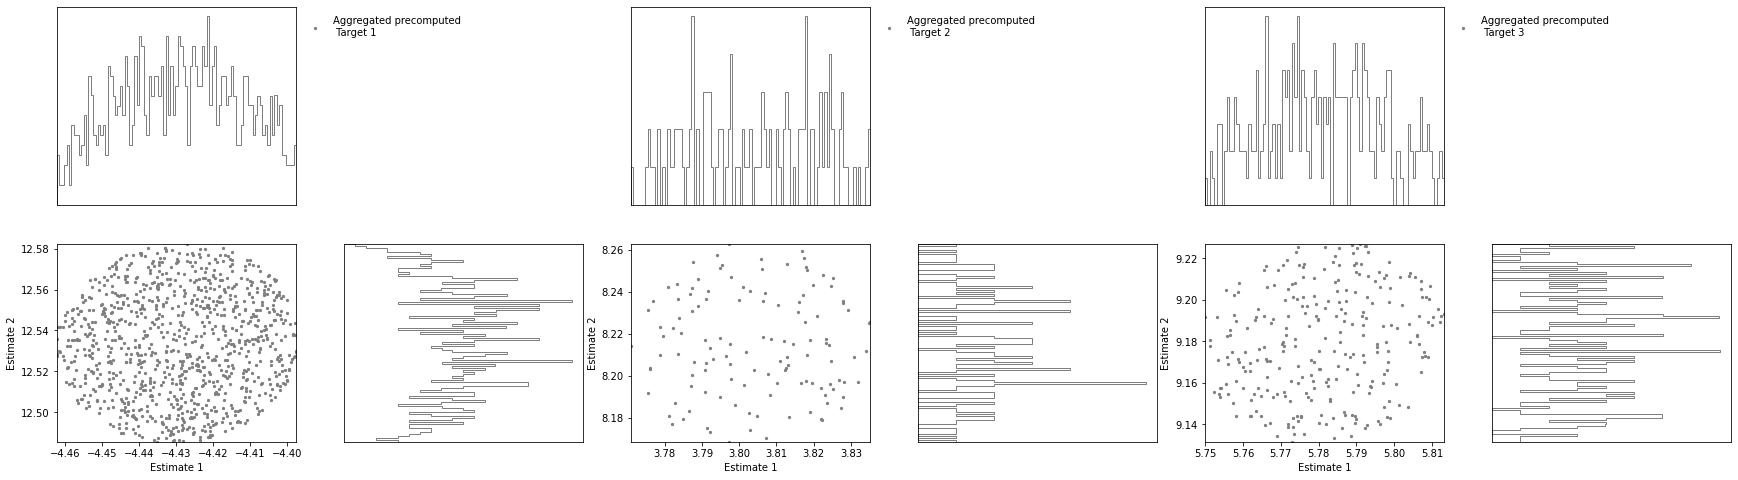

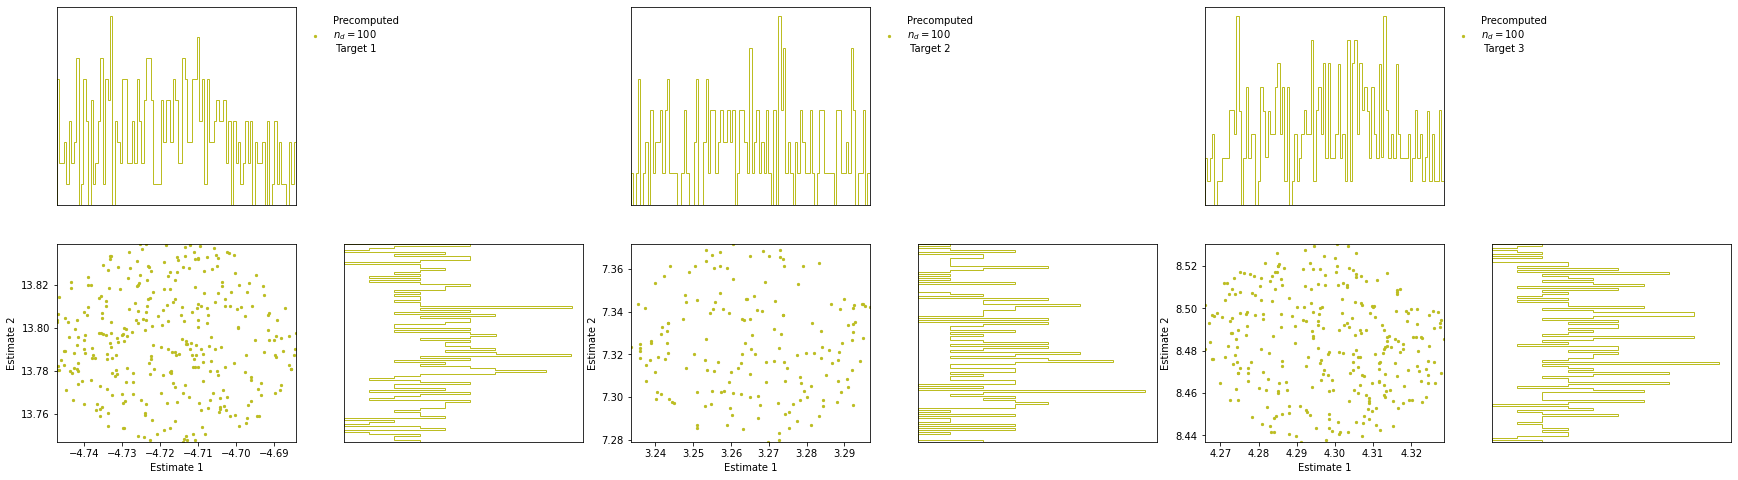

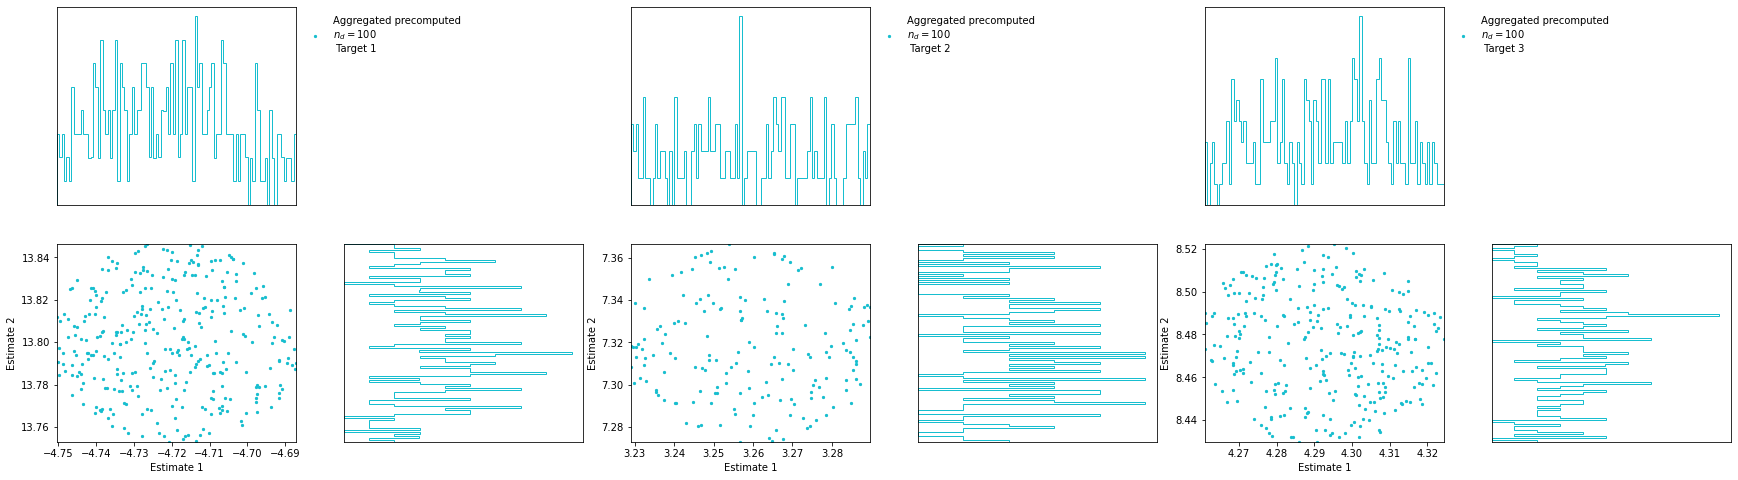

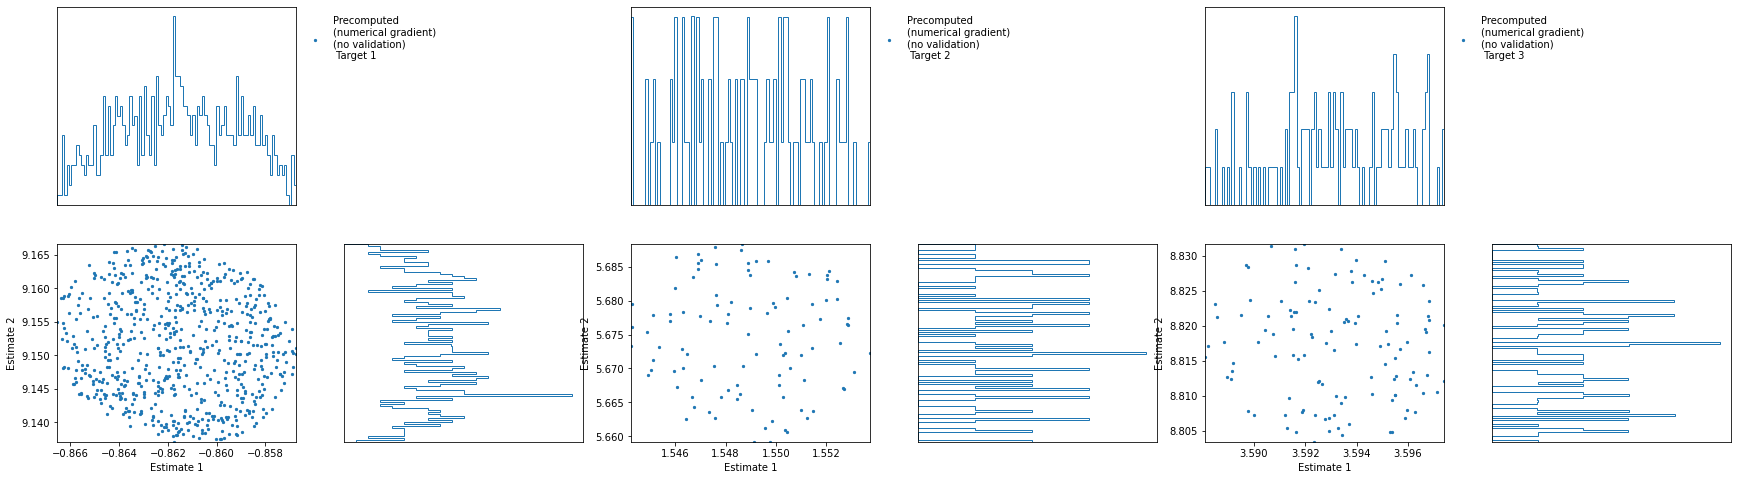

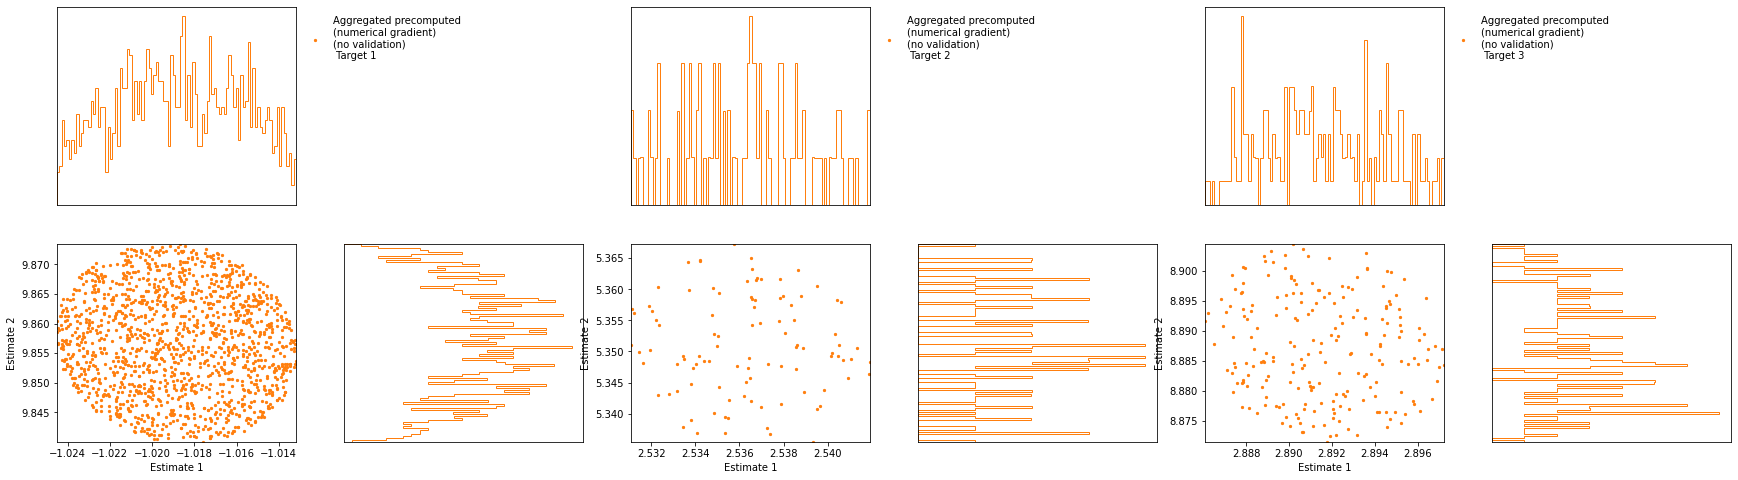

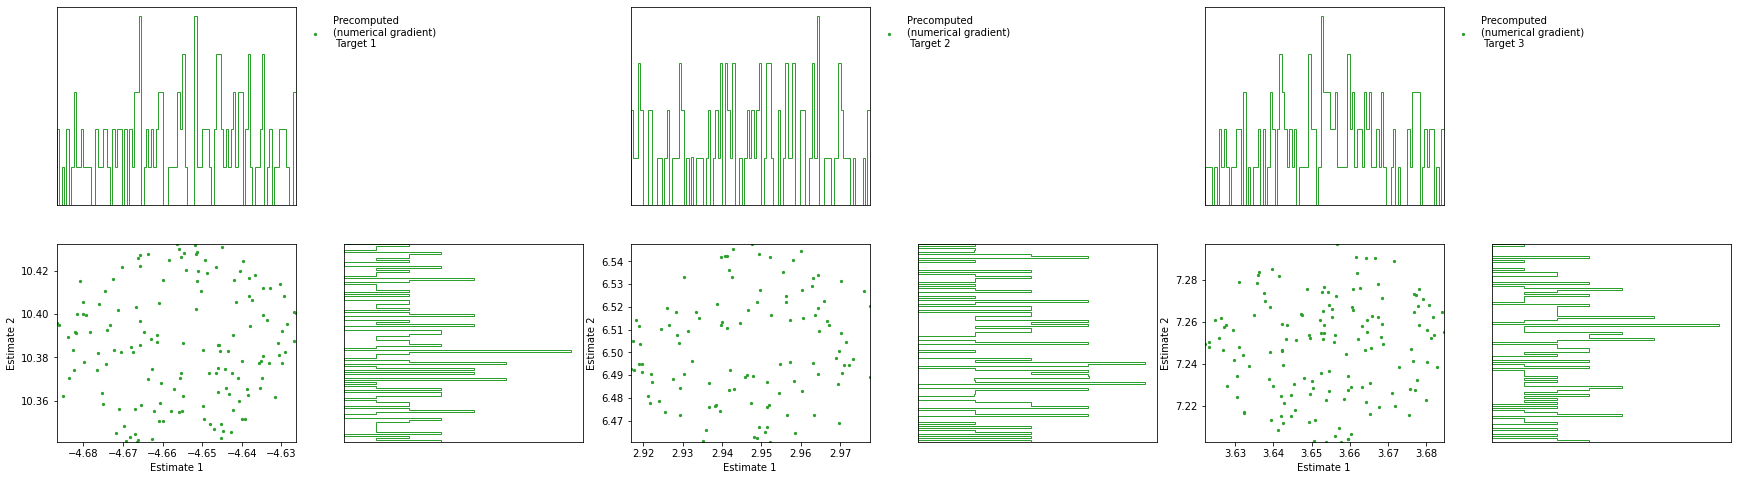

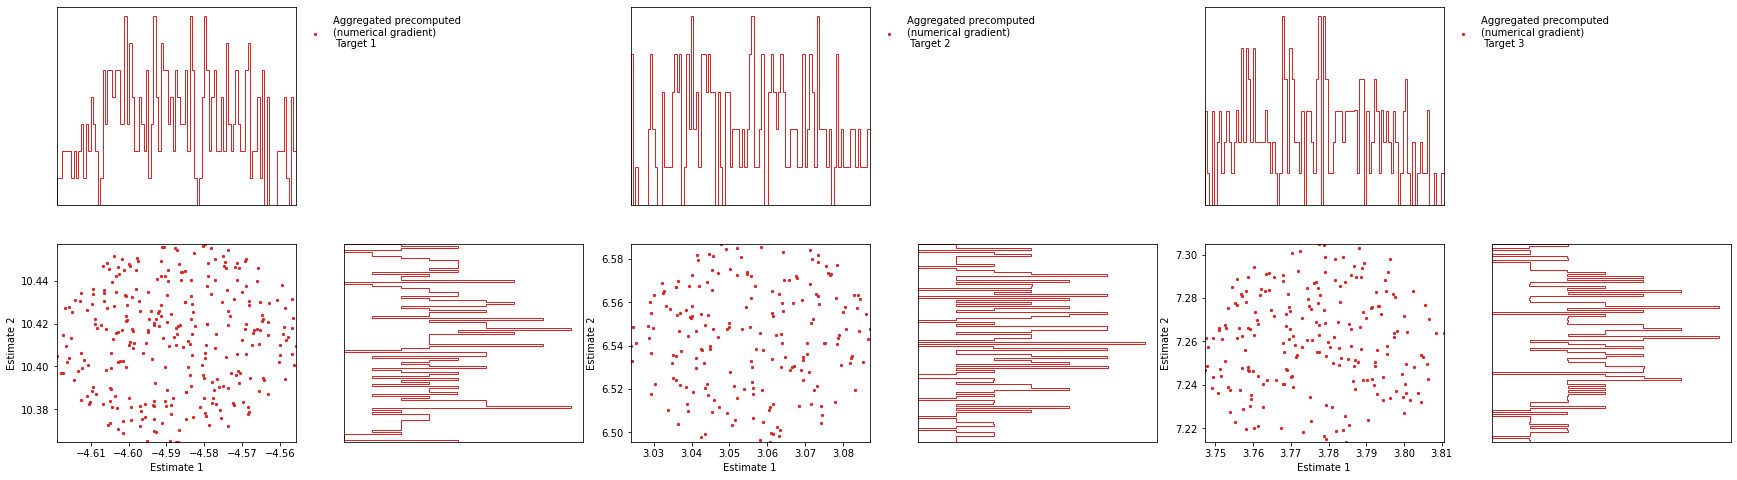

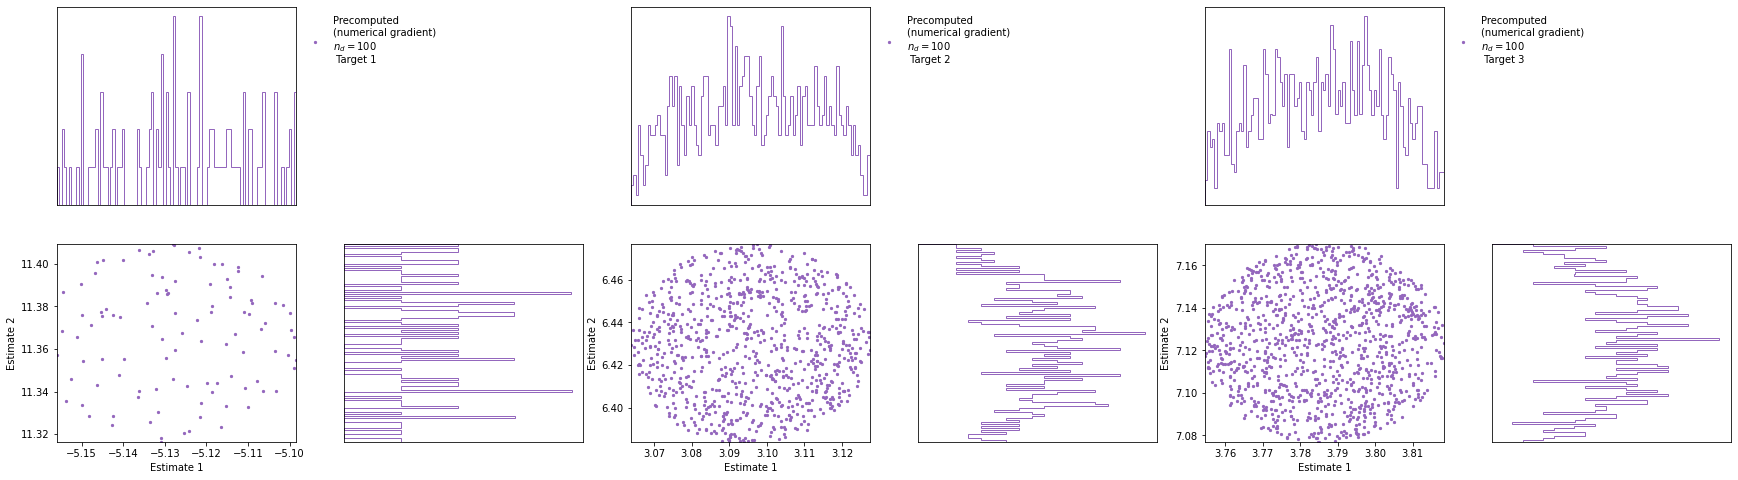

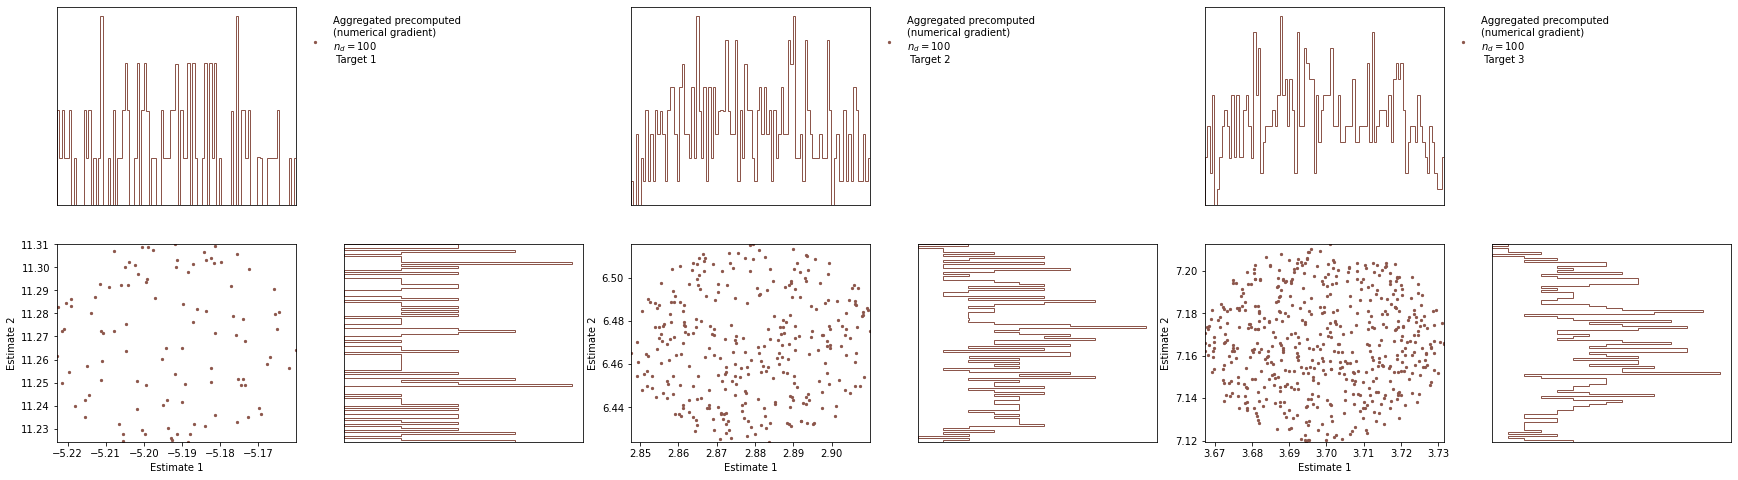

In [48]:
for i, (ABC, label) in enumerate(zip(ABCs, labels)):
    fig, ax = plt.subplots(2, 6, figsize=(30, 8))
    ABC.scatter_summaries(
        ax=ax[:, :2],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=0,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 2:4],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=1,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )
    ABC.scatter_summaries(
        ax=ax[:, 4:],
        axis_labels=["Estimate 1", "Estimate 2"],
        label=label,
        target=2,
        format=True,
        colours="C{}".format(i),
        bbox_to_anchor=(1.0, 1.0),
    )